<a href="https://colab.research.google.com/github/screemix/icv_hw/blob/main/hw1/icv_hw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to computer vision F21 Homework 1
### Completed by Chepurova Alla
BS18-DS-01
a.chepurova@innopolis.university

## Libs

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (80, 52) # (w, h)
import numpy as np
import cv2
from scipy.ndimage.filters import gaussian_filter
import scipy.stats as st


## Helper functions

In [4]:
################ Helper unctions adapted from ICV course labs #################

def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return img_result

    
def showInRow(list_of_images, titles = None, disable_ticks = False):
  plt.rcParams["figure.figsize"] = (80, 52) # (w, h)
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def generate_colors(num):
  r = lambda: np.random.randint(0, 255)
  return [(r(), r(), r()) for _ in range(num)]

################################################################################


# atapted from by https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
# works better than scipy one for my implementation
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

Pictures for testing

In [6]:
!wget https://github.com/screemix/icv_hw/blob/main/hw1/ex3.jpg?raw=true -O ex3.jpg
!wget https://github.com/screemix/icv_hw/blob/main/hw1/sudoku.jpg?raw=true -O sudoku.jpg
!wget https://github.com/screemix/icv_hw/blob/main/hw1/exer2.jpg?raw=true -O ex2.jpg

--2021-09-06 11:28:56--  https://github.com/screemix/icv_hw/blob/main/hw1/ex3.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/screemix/icv_hw/raw/main/hw1/ex3.jpg [following]
--2021-09-06 11:28:57--  https://github.com/screemix/icv_hw/raw/main/hw1/ex3.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/screemix/icv_hw/main/hw1/ex3.jpg [following]
--2021-09-06 11:28:57--  https://raw.githubusercontent.com/screemix/icv_hw/main/hw1/ex3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16852201 (16M) [applic

## Exersice 1 

Function implemenation

My approach:


- Convert image to grayscale
- Find the radius of neighbourhoud for each pixel (c = int((block_size-1)/2))
- Pad initial image with borders of size of c (see explaination above) to avoid problems regarding border pixels
- Perform tresholding - for 'mean' treshold value will be mean value of neighbourhoud of the pixel, for 'gaussian' will be weighted gaussian sum of the neighbourhoud of the pixel

In [9]:
def adaptive_thresholding(image, thresholding_type = "mean", block_size = 3, c_val=1):

  assert block_size % 2 == 1, "Block size could be only odd number"
  assert thresholding_type in ["mean", "gaussian"],  "Tresholding types could be only mean or gaussian"

  img = image.copy()

  # converting image tp grayscale if it is RGB
  if not (len(img.shape) == 2 or img.shape[2] == 1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # calculating window size for tresholding
  c = int((block_size-1)/2)

  # max value for the values that are under the treshold
  max_value = 255

  # making borders to apply tresholding on the pixels that are near the borders
  # of the image
  img = cv2.copyMakeBorder(img, c, c, c, c, cv2.BORDER_REFLECT)
  tresh_img = img.copy()

  if thresholding_type == "mean": 

    for j in range(c, img.shape[0] - c):

      for k in range(c, img.shape[1] - c):
        # calculating mean value for the pixel's neighbourhood of size c
        mean = np.mean(img[j-c:j+c+1, k-c:k+c+1]) - c_val
        # use this mean value as a treshold
        tresh_img[j, k] = max_value if img[j, k] > mean else 0
  
  elif thresholding_type == "gaussian": 
    
    for j in range(c, img.shape[0] - c):
      for k in range(c, img.shape[1] - c):
        # calculating weigthed gaussian sum for the pixel's neighbourhood of size c
        mean = np.sum(np.multiply(gkern(block_size), img[j-c:j+c+1, k-c:k+c+1])) - c_val
        # use this value as a treshold
        tresh_img[j, k] = max_value if img[j, k] > mean else 0

  return tresh_img[c:-c, c:-c]
 

Testing

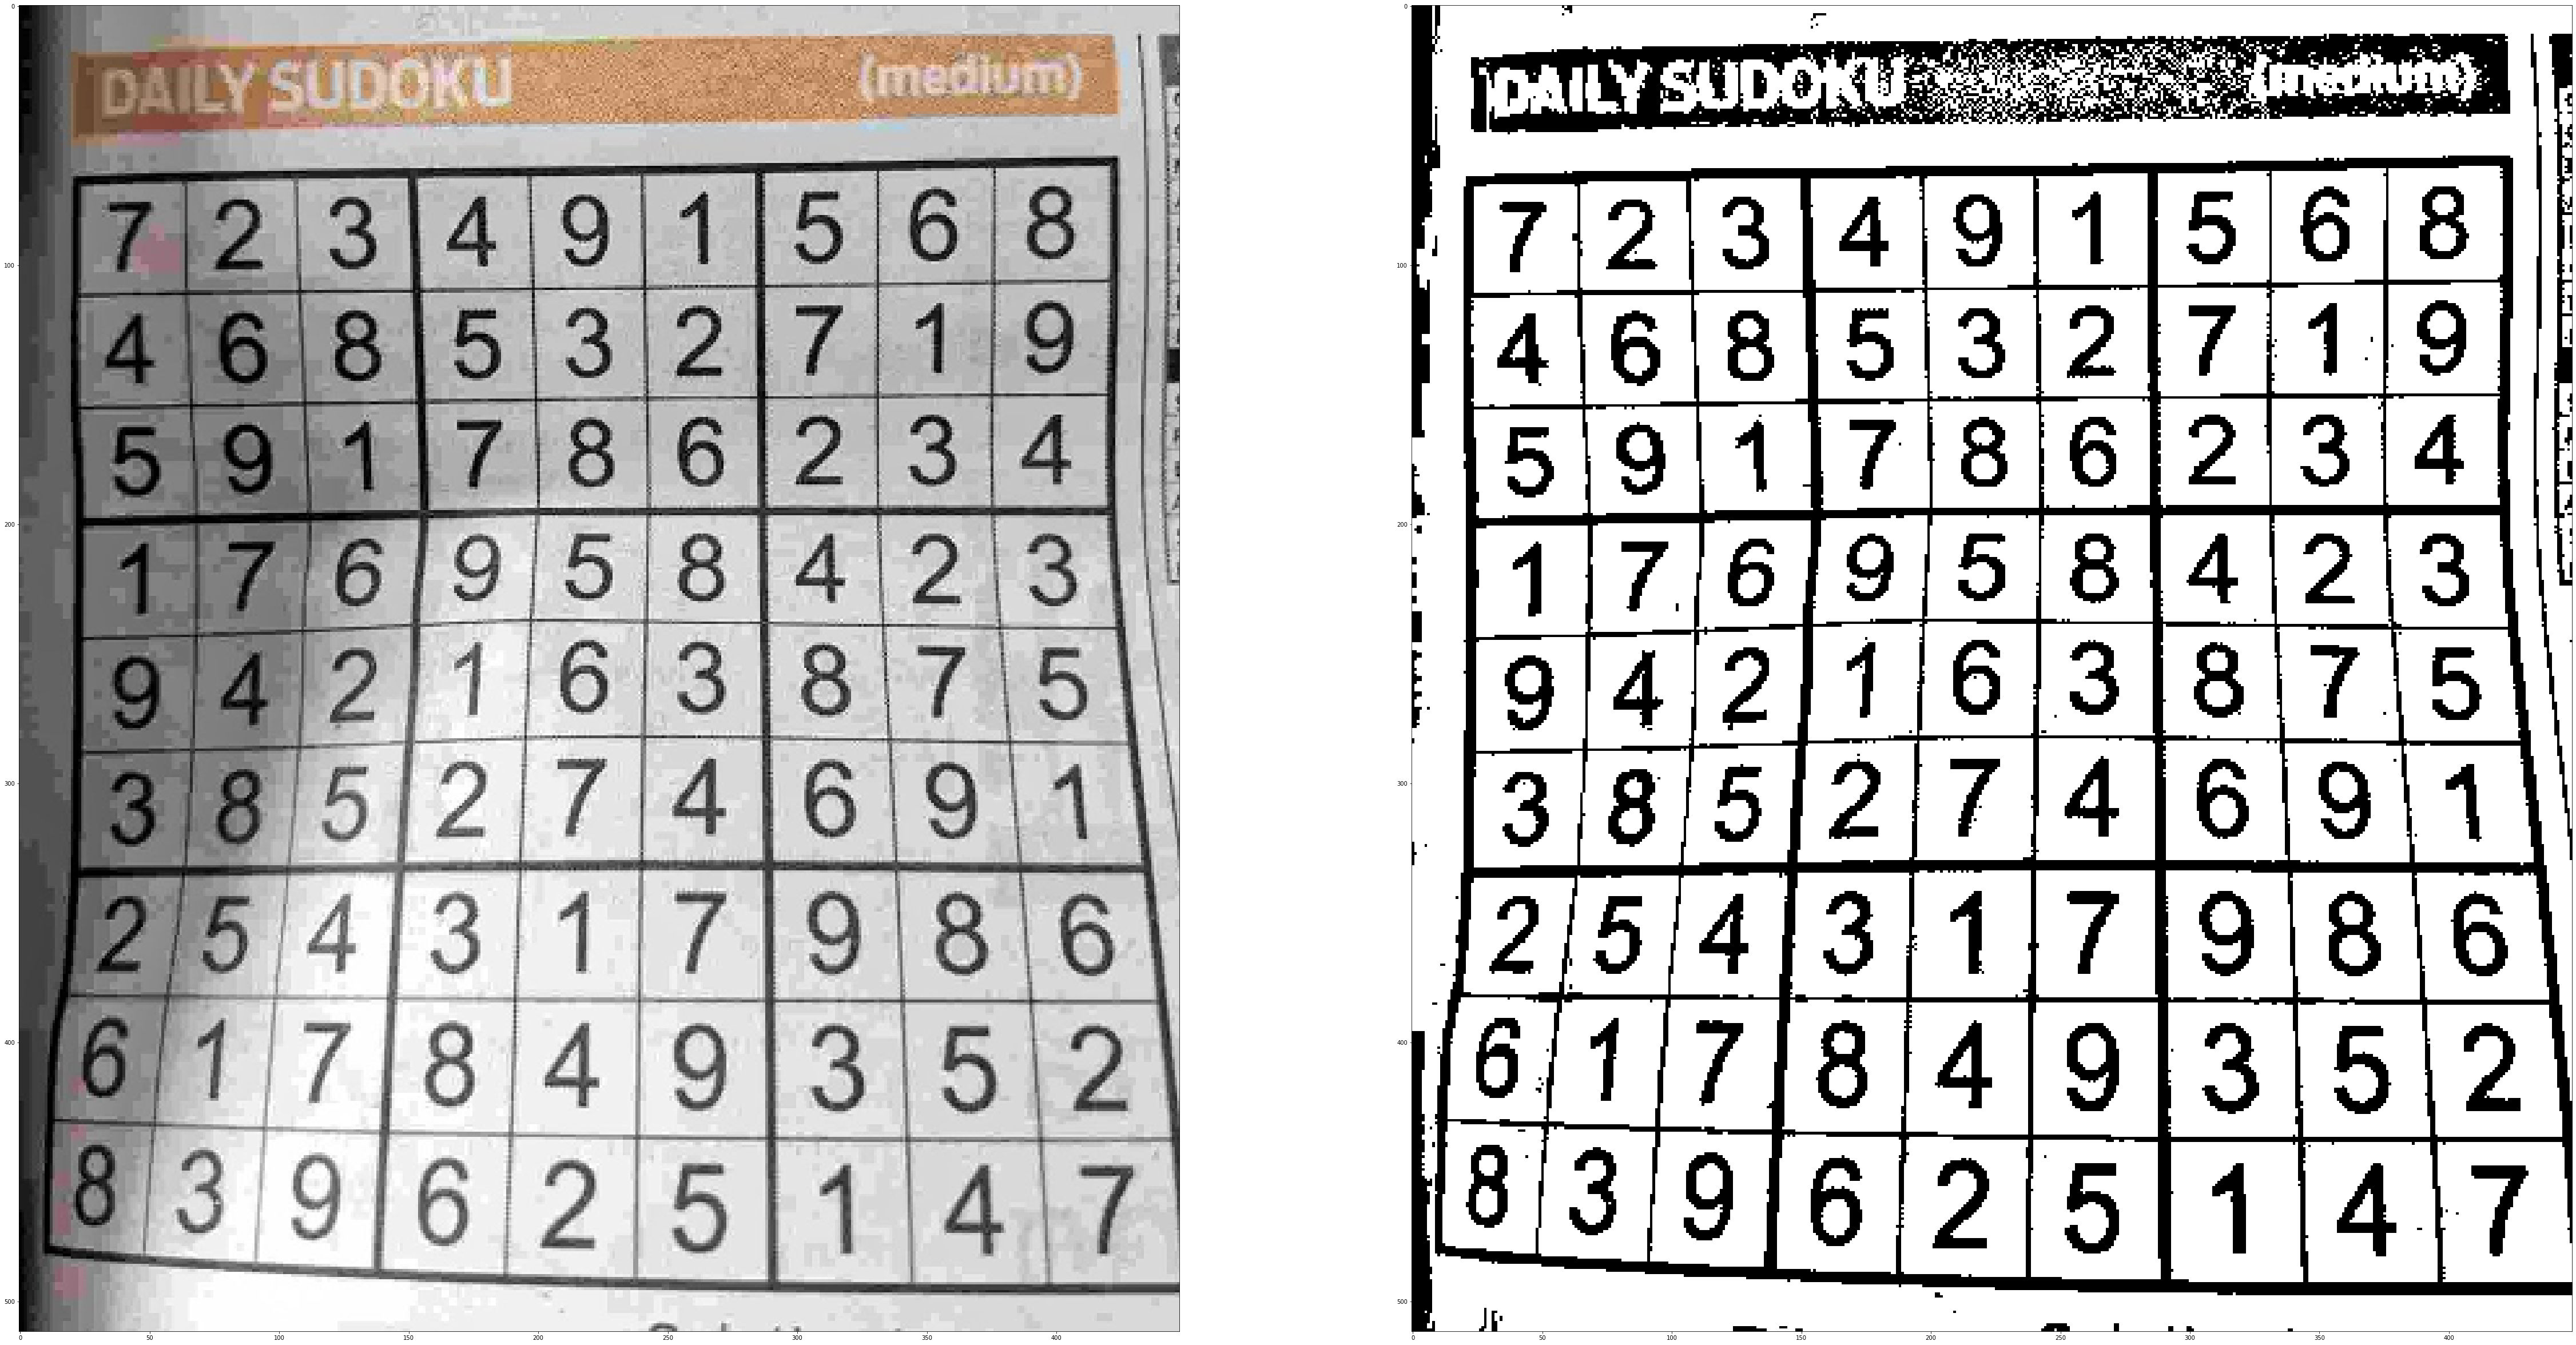

In [10]:
#@title Parameters { run: "auto" }
sudoku = read_and_resize("sudoku.jpg")
block_size_ = 39 #@param {type:"slider", min:1, max:55, step:2}
c_value_ = 10 #@param {type:"slider", min:-20, max:20, step:1}
thresholding_type_ = "mean" #@param ["mean", "gaussian"]
tr = adaptive_thresholding(sudoku, thresholding_type =thresholding_type_, block_size=block_size_, c_val=c_value_)
showInRow([sudoku, tr])

## Exersice 2

Algotithm implementation

My approach:

- Blur the image to eliminate not important edges and noise
- Apply Canny to find edges on the image
- Apply dialation to close the edges which should be connected, but due to the illumination were not
- Remove table boards with auxilary custom function that eliminate lines that touch borders of the image
- Find contours and leave only parent contours from hierarchy to save only outer contours of detected objects
- Calculate sizes features of each contour (area, perimeter, etc.)
- Rank contours by the size parameter from function call
- Draw countors and its corresponding rank, size and needed units

In [11]:
class RankObjects:

  ########### Setting up parameter for how many pixels in one mm ###########
  def __init__(self):
    self.mm_size = 3.779

  ########### Helper function to remove lines that makes table after canny ###########
  def reject_borders(self, image_):

    # adapted from https://stackoverflow.com/questions/66527607/remove-objects-that-touch-an-image-borders

    out_image = image_.copy()
    h, w = image_.shape[:2]
    for row in range(h):
        if out_image[row, 0] == 255:
            cv2.floodFill(out_image, None, (0, row), 0)
        if out_image[row, w - 1] == 255:
            cv2.floodFill(out_image, None, (w - 1, row), 0)
    for col in range(w):
        if out_image[0, col] == 255:
            cv2.floodFill(out_image, None, (col, 0), 0)
        if out_image[h - 1, col] == 255:
            cv2.floodFill(out_image, None, (col, h - 1), 0)
    return out_image

  
  ########### Helper function to convert pixels to mm ###########
  def pixels_to_mm(self, pix_amount, squared=False):
    return pix_amount/(self.mm_size**2) if squared else pix_amount/self.mm_size

  ########### Main function that calculates sizes and ranks objects ###########
  def calculate_sizes_and_rank(self, image, units="m", rank_by="area"):

    # dictionary that maps different units to function that converts pixels number
    # to these units
    unit_map = {"pixels": lambda x, b: round(x, 4), 
                "mm": lambda x, b: round(self.pixels_to_mm(x, b), 4), 
                "cm": lambda x, b: round(self.pixels_to_mm(x, b)*0.1, 4), 
                "m": lambda x, b: round(self.pixels_to_mm(x, b)*0.001, 4)}

    # dictionary that maps ranking type by the corresponding size type of object 
    rank_by_map = {"area": 0, "perimeter": 0, "height": 0, "width": 0}

    # asserts to check the parameters from input
    assert units in unit_map.keys(), "Invalid unit parameter value - {}".format(units)
    assert rank_by in rank_by_map.keys(), "Invalid rank_by parameter value - {}".format(rank_by)

    # auxilary variable for area unit
    units_square = units if units == 'pixels' else units + "^2"

    # blurring image from input and detect edges to highlight objects contours on the image
    # bluring eliminates noise and makes more precise edges as a result from Canny
    im = image.copy()
    blur = cv2.GaussianBlur(im, (7,7),0)
    edges = cv2.Canny(blur, threshold1=50, threshold2=100)
    
    # applying dialation to connect edges that are belong to the same objects, but
    # disconnected due to the non-uniform illumination
    kernel = np.ones((6, 6),np.uint8)
    dilation = cv2.dilate(edges, kernel, iterations = 1)

    # removing lines that touches borders, therefore belong to table
    removed_bord = self.reject_borders(dilation)

    # finding the contours of objects and eliminate child countours (ones inside
    # the borders of objects itself) with parameters RETR_EXTERNAL
    contours, hierarchy = cv2.findContours(removed_bord, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(im, contours, -1, (255,0,0), 3)

    # Once we found all contours of objects on images, we need to draw it and 
    # label each object with it's rank and size features

    # width of image
    im_width = im.shape[1]

    # containers for features of detected objects
    perimeters = []
    areas = []
    centers = []
    heights = []
    widths = []
    sorting_criteria = []


    for i, contour in enumerate(contours):
      # for each contour object we calculate its perimeter, area, width, 
      # heigth and centers (momentums)

      perimeter = unit_map[units](cv2.arcLength(contour, True), False)
      area = unit_map[units](cv2.contourArea(contour), True)
      _, _, w, h = cv2.boundingRect(contour)
      w = unit_map[units](w, False)
      h = unit_map[units](h, False)
      M = cv2.moments(contour)
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])

      perimeters.append(perimeter)
      areas.append(area)
      centers.append((cX, cY))
      heights.append(h)
      widths.append(w)

      # then we define on which criteria we rank objects
      rank_by_map = {"area": area, "perimeter": perimeter, "height": h, "width": w}

      # and append it to the array of tuples to sort them afterwards by size as 
      # a main criteria and by the place on the picture (from left to one) as a 
      # second criteria
      sorting_criteria.append((i, rank_by_map[rank_by], im_width - cX))
      
    
    # sort objects on the pictupre by size and place
    sorting_criteria = sorted(sorting_criteria, key = lambda x: (x[1], x[2]), reverse=True)

    # map rank of each object to its index
    ranks = {}
    for j, elem in enumerate(sorting_criteria):
      ranks[elem[0]] = j

    # labels each cotour's object with its features (e.g. rank, area, etc.)
    for i, contour in enumerate(contours): 
      
      text = 'Rank {}*Area {} {}*Perimeter {} {}*Heigth {} {}*Width {} {}'.format(ranks[i]+1, areas[i], units_square, perimeters[i], units, heights[i], units, widths[i], units)
      cX, y0, dy = centers[i][0], centers[i][1], 15

      # for each object we plot features on the separate line distanced by 
      # 15 pixels from previous one
      for k, line in enumerate(text.split('*')):
        y = y0 + k*dy
        cv2.putText(im, line, (cX, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

    sizes = (heights , widths , perimeters , areas)
    return im, sizes

Testing

In [12]:
ranker = RankObjects()
ex2 = read_and_resize("ex2.jpg")

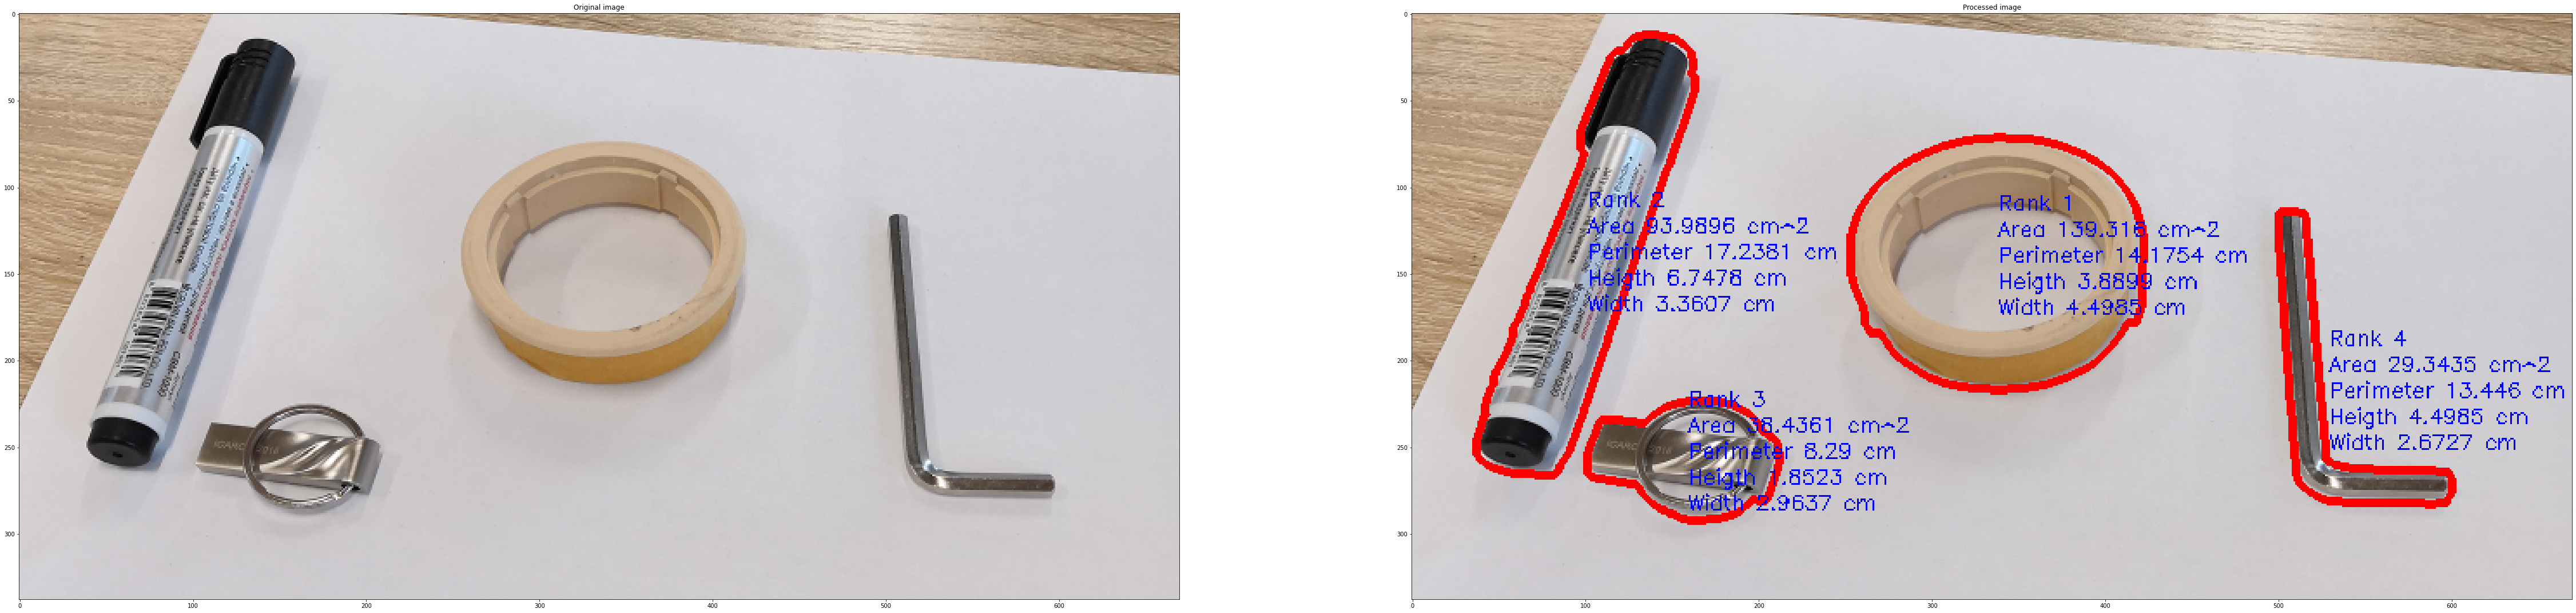

In [13]:
#@title Parameters { run: "auto" }
rank_by_ = 'area' #@param ["height", "width", "perimeter", "area"]
units_ = "cm" #@param ["m", "mm", "cm", "pixels"]

result_image_2, features = ranker.calculate_sizes_and_rank(ex2, units=units_, rank_by=rank_by_)
showInRow([ex2, result_image_2], ["Original image", "Processed image"])

## Exercise 3

Function implementation

My approach:
- Convert image to grayscale
- Blur the image to eliminate noise and contrast between objects (but there still will be the contrast of coins which are on the paper)
- Apply tresholding to **highlight coins on the paper background** and **merge the coins that are placed on the borders with the table background**, so that only circles that left would be the coins that are fully on the paper
- Apply erosion for better dividing coins from the paper sheet
- Apply connectivity analysis to find clusters
- Substract 2 from number of connected components on the image as we do not need to include background and sheet on the overall number of coins

In [19]:
def coins_calculator(image, verbose=False) :
  
  # converting image to grayscale if necessary
  if not (len(image.shape) == 2 or image.shape[2] == 1):
    coin_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else: 
    coin_img = image.copy()
  
  blur_size = 83
  # bluring the image
  coins_blur = cv2.GaussianBlur(coin_img, (blur_size, blur_size), 0)

  # applying binary tresholding to highlight coins on the background of the sheet
  _, coins_thresh = cv2.threshold(coins_blur, 190, 255, cv2.THRESH_BINARY_INV)

  # applying erosion to separate coins from each other
  erode_size = 69
  coins_erode = cv2.erode(coins_thresh, (erode_size, erode_size), iterations = 5)  

  # applying connectivity analysis to find number of coins + leaf + background
  connectivity = 8
  n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(coins_erode, connectivity, cv2.CV_32S)

  # substracting leaf and background from nymber of found components
  # to obtain number of coins
  total_val = n_labels - 2

  if verbose:
    
    # generate different colors for each cluster
    colors = generate_colors(n_labels)

    # new black image for the background
    labeled_image = np.zeros((coin_img.shape[0], coin_img.shape[1],3), dtype=np.uint8)

    # for each cluster except two first ones (background and leaf) we calculate 
    # the center and assign the color then draw it on the new black picture
    # for visualization
    for i, label in enumerate(range(2, n_labels)):
        labeled_image[labels == label,:]= colors[i]

        x, y = list(map(int, centroids[label]))
        
        # drawing a center of the cluster
        cv2.circle(labeled_image, (x, y), 10, (0,0,255), -1)

    showInRow([coin_img, labeled_image])
  
  return total_val

Testing

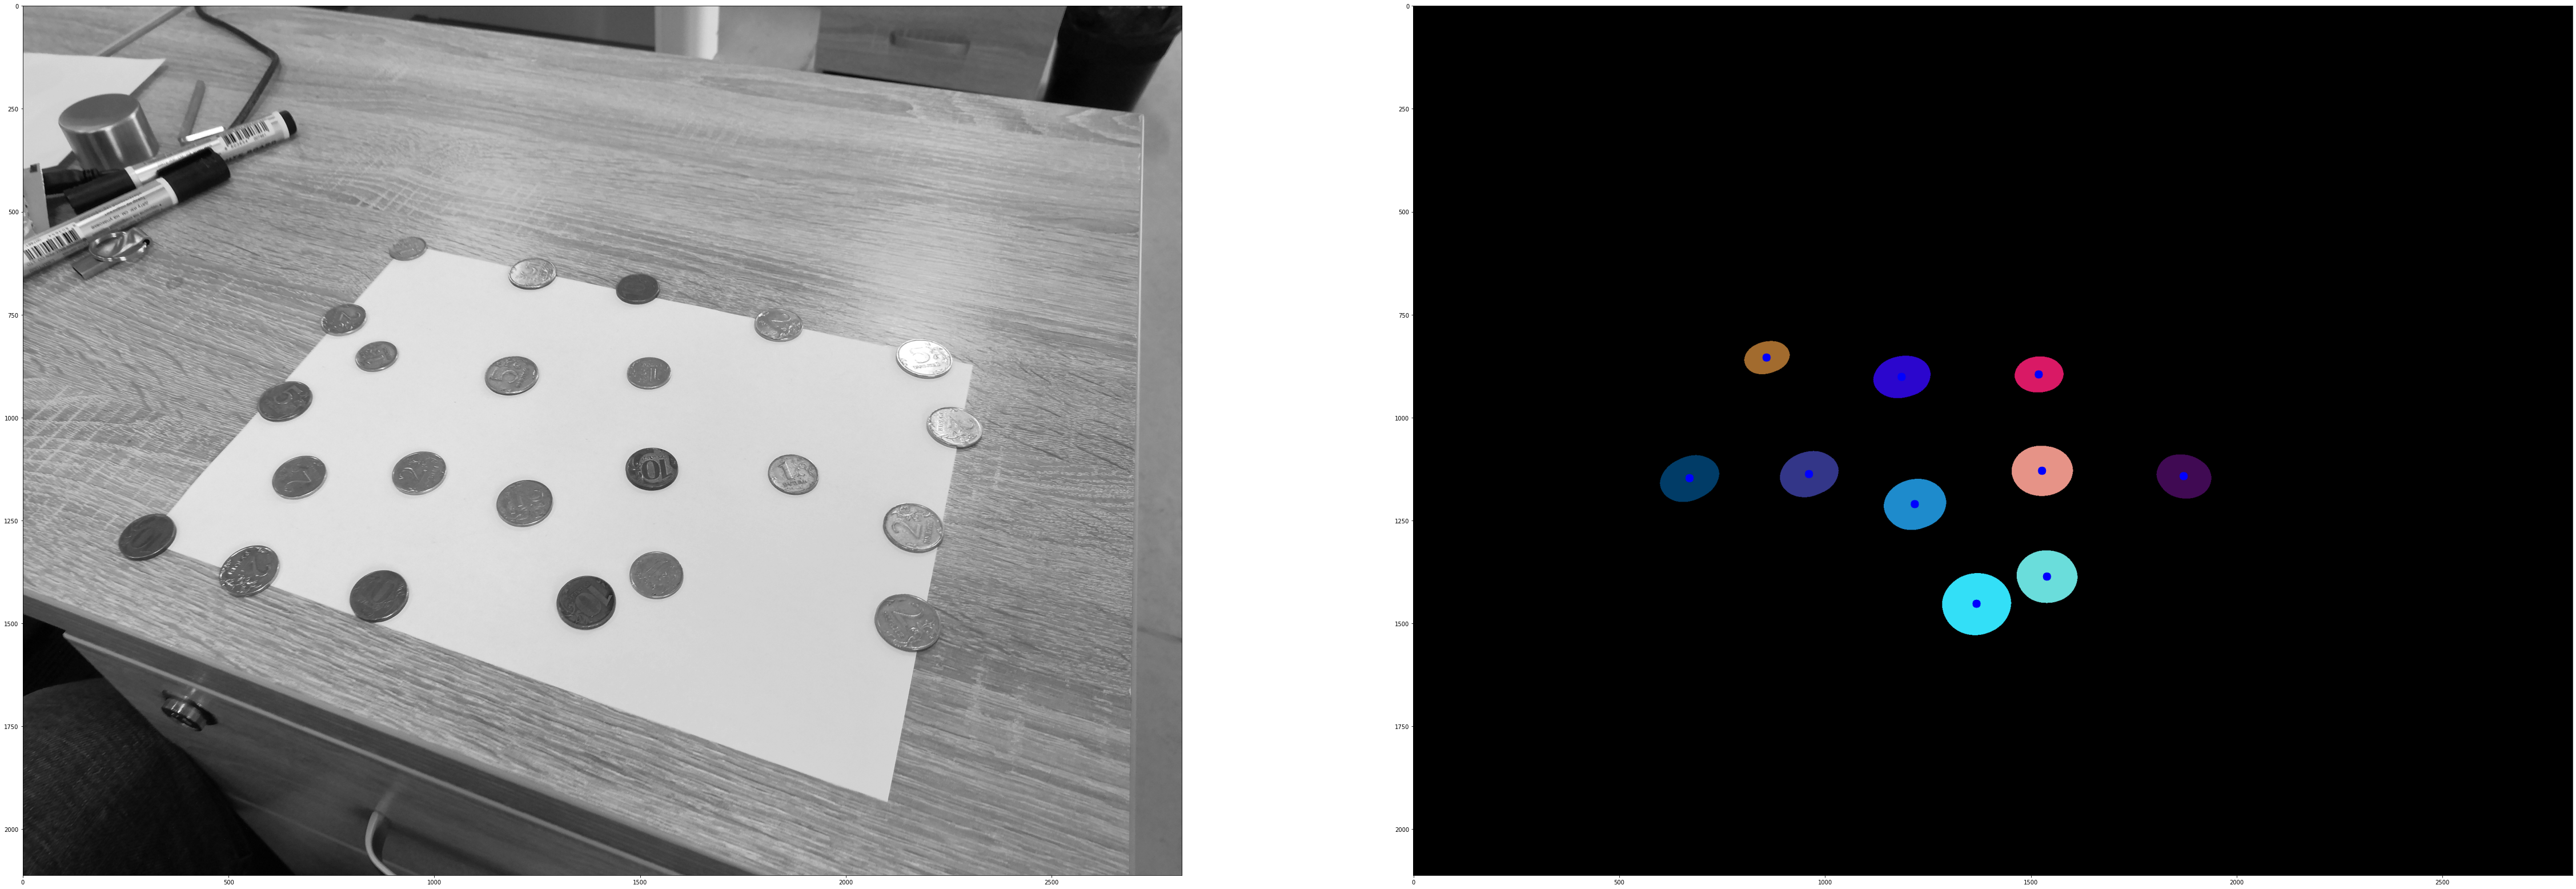


There are 10 coins


In [20]:
ex3 = read_and_resize("ex3.jpg")
num_coins = coins_calculator(ex3, True)
print()
print("There are {} coins".format(num_coins))